In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from ggplot import *

/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
from sqlalchemy import create_engine

# Prepare data for exploratory data analyses
1. Date of metric by fact, by document type/primary org (e.g., page views over date-dimension stratified by document type)
2. content-specific performance metric (e.g. reading age) by user-related performance metric (e.g., page views) over a defined time-period (min-max in date dimension)

### Read in data

In [4]:
engine = create_engine('postgresql://ellieking@localhost:5432/givedata')

/Users/ellieking/Documents/give-depts-data/give_data/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
facts_metrics = pd.read_sql_query('select * from "facts_metrics"',con=engine)

In [6]:
items = pd.read_sql_query('select * from "dimensions_items"',con=engine)

### Join facts_metrics to specific item variables

In [7]:
content_performance_bytime = pd.merge(
    left=facts_metrics,
    right=items[['id', 'document_type']],
    left_on='dimensions_item_id', # which taxon is the content item tagged to
    right_on='id', # what is the id of that taxon
    how='outer', # keep everything for checking merge
    indicator=True # so we can filter by match type
)

In [8]:
content_performance_bytime.groupby('_merge').size()

_merge
left_only           0
right_only          1
both          4197562
dtype: int64

In [ ]:
content_performance_bytime.to_csv('../DATA/content_performance_bytime', compression='gzip')

In [9]:
content_performance_bytime[content_performance_bytime['_merge']=='right_only']

,id_x,dimensions_date_id,dimensions_item_id,created_at,updated_at,pageviews,unique_pageviews,feedex_comments,id_y,document_type,_merge
4197562,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,3551332,None,right_only


### Dates to index for plots

In [10]:
content_performance_bytime['date'] = pd.to_datetime(content_performance_bytime['dimensions_date_id'])

In [11]:
content_performance_bytime.index = content_performance_bytime['date']

### Page views over time, by doc type

In [79]:
def plot_time_metric_byvar(df, metric, byvar):
    grouped = df.groupby([byvar, pd.Grouper(freq='D')])[metric].sum()
    by_day = grouped.unstack(byvar, fill_value=0)
    top = by_day.iloc[:, by_day.columns.isin(by_day.min().sort_values(ascending=False)[:10].index)]
    bottom = by_day.iloc[:, by_day.columns.isin(by_day.min().sort_values()[:10].index)]
    
    ax = top.plot()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ay = bottom.plot()
    ay.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return ax, ay
    

(<matplotlib.axes._subplots.AxesSubplot at 0x1bf54ab00>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b6d84ef0>)

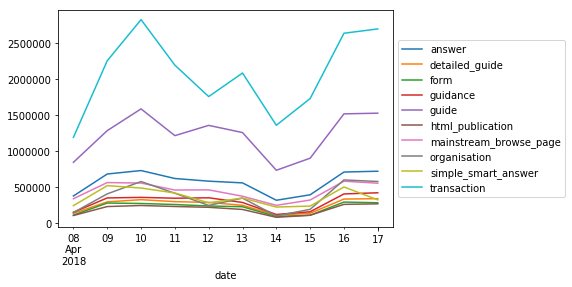

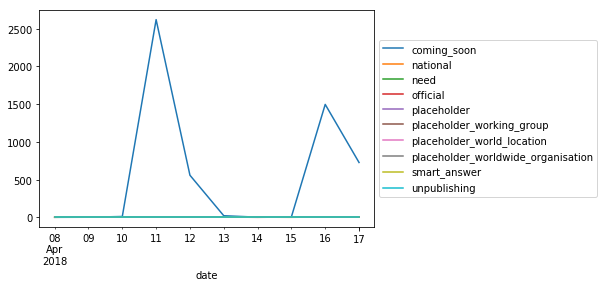

In [80]:
plot_time_metric_byvar(df=content_performance_bytime, metric='pageviews', byvar='document_type')

In [26]:
doctype_grouped = content_performance_bytime.groupby(['document_type', pd.Grouper(freq='D')])['pageviews'].sum()

In [27]:
doctype_grouped

document_type           date      
aaib_report             2018-04-08     1636.0
                        2018-04-09     2168.0
                        2018-04-10     1616.0
                        2018-04-11     1657.0
                        2018-04-12     1820.0
                        2018-04-13     2517.0
                        2018-04-14     1367.0
                        2018-04-15     1488.0
                        2018-04-16     1807.0
                        2018-04-17     1888.0
about                   2018-04-08     4512.0
                        2018-04-09     9859.0
                        2018-04-10    10415.0
                        2018-04-11     9600.0
                        2018-04-12     9333.0
                        2018-04-13     7815.0
                        2018-04-14     3620.0
                        2018-04-15     4739.0
                        2018-04-16    10861.0
                        2018-04-17    10679.0
about_our_services      2018-04-08     1297.0

In [30]:
doctype_by_day = doctype_grouped.unstack('document_type', fill_value=0)

In [64]:
doctype_by_day.columns

Index(['aaib_report', 'about', 'about_our_services', 'access_and_opening',
       'answer', 'asylum_support_decision', 'authored_article',
       'business_finance_support_scheme', 'calculator', 'calendar',
       ...
       'travel_advice_index', 'unpublishing', 'utaac_decision',
       'welsh_language_scheme', 'working_group', 'world_location',
       'world_location_news_article', 'world_news_story',
       'worldwide_organisation', 'written_statement'],
      dtype='object', name='document_type', length=141)

In [61]:
doctype_by_day.min().sort_values(ascending=False)[:10].index

Index(['transaction', 'guide', 'answer', 'mainstream_browse_page',
       'simple_smart_answer', 'guidance', 'detailed_guide', 'organisation',
       'form', 'html_publication'],
      dtype='object', name='document_type')

In [67]:
doctype_by_day.columns.isin(doctype_by_day.min().sort_values(ascending=False)[:10].index)

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [69]:
doctype_by_day.iloc[:, doctype_by_day.columns.isin(doctype_by_day.min().sort_values(ascending=False)[:10].index)]

document_type,answer,detailed_guide,form,guidance,guide,html_publication,mainstream_browse_page,organisation,simple_smart_answer,transaction
date,,,,,,,,,,
2018-04-08,379931.0,139298.0,114739.0,154098.0,846985.0,109163.0,342428.0,150520.0,246094.0,1193136.0
2018-04-09,684770.0,298206.0,282203.0,353049.0,1286113.0,233423.0,565964.0,409212.0,523613.0,2254905.0
2018-04-10,732596.0,329034.0,275999.0,360746.0,1587596.0,248165.0,559144.0,580302.0,490295.0,2824735.0
2018-04-11,622415.0,301323.0,261700.0,349053.0,1216551.0,234356.0,462603.0,417667.0,421481.0,2193918.0
2018-04-12,585420.0,291225.0,241308.0,355073.0,1359007.0,223015.0,464781.0,249368.0,285804.0,1758086.0
2018-04-13,561696.0,250599.0,230943.0,290182.0,1259375.0,193263.0,376788.0,350410.0,352354.0,2084683.0
2018-04-14,320777.0,113231.0,95696.0,123932.0,736640.0,84296.0,250190.0,104624.0,226613.0,1360302.0
2018-04-15,396516.0,140756.0,113282.0,161294.0,904073.0,112745.0,324051.0,194799.0,240013.0,1730897.0
2018-04-16,712019.0,337236.0,295721.0,408504.0,1518615.0,263811.0,585037.0,602422.0,505261.0,2636359.0


In [59]:

#There are too many document types to plot on one chart so select the types with highest maximum
top_views = doctype_by_day.loc[:,doctype_by_day.min().sort_values(ascending=False)[:10]]

ax = top_views.plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

KeyError: 'None of [document_type\ntransaction               1193136.0\nguide                      736640.0\nanswer                     320777.0\nmainstream_browse_page     250190.0\nsimple_smart_answer        226613.0\nguidance                   123932.0\ndetailed_guide             113231.0\norganisation               104624.0\nform                        95696.0\nhtml_publication            84296.0\ndtype: float64] are in the [columns]'

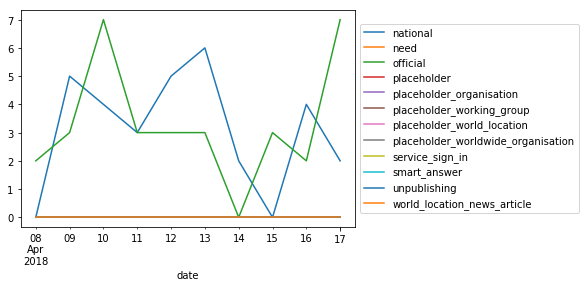

In [52]:

#There are too many document types to plot on one chart so select the types with highest maximum
bottom_views = doctype_by_day.loc[:,doctype_by_day.max() < 10]

ax = bottom_views.plot()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Document types with no page views in date range

In [45]:
#over the whole month (includes entire data range) total number of page views 

x = content_performance_bytime.groupby(['document_type', pd.Grouper(freq='M')])['pageviews'].sum()

In [50]:
#which documen types had no page views
x[x==0]

document_type                       date      
need                                2018-04-30    0.0
placeholder                         2018-04-30    0.0
placeholder_organisation            2018-04-30    0.0
placeholder_working_group           2018-04-30    0.0
placeholder_world_location          2018-04-30    0.0
placeholder_worldwide_organisation  2018-04-30    0.0
service_sign_in                     2018-04-30    0.0
smart_answer                        2018-04-30    0.0
unpublishing                        2018-04-30    0.0
world_location_news_article         2018-04-30    0.0
Name: pageviews, dtype: float64

In [ ]:
dates = pd.read_sql_query('select * from "dimensions_dates"',con=engine)

In [ ]:
dates['date'] = pd.to_datetime(dates['date'])

In [ ]:
min(dates['date'])

In [ ]:
max(dates['date'])

In [ ]:
items.shape

In [ ]:
feedex = pd.read_sql_query('select * from "events_feedexes"',con=engine)

In [ ]:
feedex.shape

In [ ]:
ga = pd.read_sql_query('select * from "events_gas"',con=engine)

In [ ]:
ga.shape

In [ ]:
facts_metrics.head()

In [ ]:
facts_metrics.shape

In [ ]:
facts_metrics.id.nunique()

In [ ]:
facts_metrics.groupby('dimensions_item_id').size().describe()

In [ ]:
facts_metrics.groupby('dimensions_date_id').size().describe()

In [ ]:
facts_metrics[facts_metrics['dimensions_item_id']==3063339]

In [ ]:
facts_metrics.groupby(['dimensions_date_id', 'dimensions_item_id', 'id']).sum()

In [ ]:
facts_metrics.groupby('dimensions_item_id').sum()

In [ ]:
facts_metrics.dimensions_item_id.nunique()

In [ ]:
facts_metrics.dimensions_date_id.nunique()

In [ ]:
schema = pd.read_sql_query('select * from "schema_migrations"',con=engine)

In [ ]:
schema.head()

In [ ]:
schema.shape